In [ ]:
#| default_exp core.criteria

In [ ]:
#| export
from __future__ import annotations
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastcore.basics import *
from fastcore.imports import *
from fasterai.core.granularity import *
from typing import Callable
from enum import Enum, auto

The criteria implemented come from [this paper](https://arxiv.org/pdf/1905.01067.pdf).

In [ ]:
#| include: false
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *
from nbdev.showdoc import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#| include: false
limit = np.linspace(-1, 1, 100)

def demo_model(criteria, sparsity=50):
    model = models.resnet18(pretrained=True)
    
    #sp = Sparsifier(model, 'weight', 'local', criteria)
    
    pt = model.conv1.weight.clone().view(-1).detach().numpy()
    model.conv1._init_weights =  model.conv1.weight.clone()
    model.conv1.weight.data += 0.05*torch.randn(model.conv1.weight.shape)
    ft = model.conv1.weight.clone().view(-1).detach().numpy()
    
    
    pruned_weights = criteria(model.conv1, 'weight')
    threshold = torch.quantile(pruned_weights.view(-1), sparsity/100)
    mask = pruned_weights.ge(threshold).to(dtype=pruned_weights.dtype)
    
    
    keep = np.where(mask.view(-1)==1)
    pruned = np.where(mask.view(-1)==0)
    fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=100)
    fig.patch.set_alpha(0.)
    ax.patch.set_alpha(0.)
    x1, x2, y1, y2 = -0.4, 0.4, -0.4, 0.4 # specify the limits
    ax.set_xlim(x1, x2) # apply the x-limits
    ax.set_ylim(y1, y2) # apply the x-limits
    ax.scatter(pt[pruned], ft[pruned], s=5, c='lightgrey')
    ax.scatter(pt[keep], ft[keep], s=5, c='#89d6c9')
    ax.plot(limit, limit, c='black', linestyle=':', linewidth=3)
    ax.set_xlabel("Pretrained Weights", fontsize=15)
    ax.set_ylabel("Fine-Tuned Weights", fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
    plt.tick_params(axis='x', labelsize=15, width=2)
    plt.tick_params(axis='y', labelsize=15, width=2)
    ax.spines['bottom'].set_color('#808080')
    ax.spines['top'].set_color('#808080') 
    ax.spines['right'].set_color('#808080')
    ax.spines['left'].set_color('#808080')
    ax.tick_params(axis='x', colors='#808080')
    ax.tick_params(axis='y', colors='#808080')
    ax.yaxis.label.set_color('#808080')
    ax.xaxis.label.set_color('#808080')

In [ ]:
#| export
EPS = torch.finfo(torch.float32).eps

In [ ]:
#| export
class Reducer:
    @staticmethod
    def sum(scores, dim):
        return scores[None].sum(dim=dim, keepdim=True).squeeze(0)
    
    @staticmethod
    def mean(scores, dim):
        return scores[None].mean(dim=dim, keepdim=True).squeeze(0)

In [ ]:
show_doc(Reducer)

Found permutation search CUDA kernels
[ASP][Info] permutation_search_kernels can be imported.


---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/criteria.py#L24){target="_blank" style="float:right; font-size:smaller"}

### Reducer

```python

def Reducer(
    args:VAR_POSITIONAL, kwargs:VAR_KEYWORD
):


```

*Initialize self.  See help(type(self)) for accurate signature.*

In [ ]:
#| export
class Normalizer:
    @staticmethod
    def sum(scores):
        return scores / scores.sum()
    
    @staticmethod
    def standardization(scores):
        return (scores - scores.min()) / (scores.max() - scores.min() + EPS)
    
    @staticmethod
    def mean(scores):
        return scores / scores.mean()
    
    @staticmethod
    def max(scores):
        return scores / scores.max()
    
    @staticmethod
    def gaussian(scores):
        return (scores - scores.mean()) / (scores.std() + EPS)

In [ ]:
show_doc(Normalizer)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/criteria.py#L34){target="_blank" style="float:right; font-size:smaller"}

### Normalizer

```python

def Normalizer(
    args:VAR_POSITIONAL, kwargs:VAR_KEYWORD
):


```

*Initialize self.  See help(type(self)) for accurate signature.*

In [ ]:
#| export
class Criteria():
    def __init__(self, 
                 f:Callable[[torch.Tensor], torch.Tensor],                                         # Function that transforms weights (e.g., torch.abs, torch.square)
                 reducer: Callable = Reducer.mean,                                                 # Method to reduce dimensions ('mean' or 'sum')
                 normalizer: Callable | None = None,                                               # Method to normalize scores (None, 'sum', 'standardization', 'mean', 'max', 'gaussian')
                 needs_init:bool=False,                                                            # Whether this criteria needs the initial weights
                 needs_update:bool=False,                                                          # Whether this criteria needs to track weight updates between iterations
                 output_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor] | None = None,    # Function to combine current and reference weights
                 return_init=False,                                                                # Whether to return the transformed initial weights instead of final output
    ):
        "Evaluates neural network parameters based on various criteria for pruning"
        store_attr()
        assert (needs_init and needs_update)==False, "The init values will be overwritten by the updating ones."
   
    @torch.no_grad()
    def __call__(self, 
                 m: nn.Module,  # The module to compute scores for
                 g: str,        # Granularity specification
                 squeeze=False  # Whether to squeeze singleton dimensions
    ) -> torch.Tensor:
        "Compute criteria scores for module weights"
        try:
            dim = listify(Granularities.get_dim(m, g))
        except KeyError:
            raise ValueError(f'Invalid granularity "{g}" for module type {type(m).__name__}')
            
        if self.needs_update and not hasattr(m, '_old_weights'):
            m.register_buffer("_old_weights", m._init_weights.clone()) # If the previous value of weights is not known, take the initial value
            
        wf = self.f(m.weight)
        
        if self.needs_init: wi = self.f(m._init_weights)
        if self.needs_update: wi = self.f(m._old_weights)
        
        if self.output_fn: scores = self.output_fn(wf, wi)
        elif self.return_init: scores = wi
        else: scores = wf
            
        scores = self._rescale(scores)
        if hasattr(m, '_mask'): scores.mul_(m._mask)
        scores = self._reduce(scores, dim)
        scores = self._normalize(scores)
        if squeeze: scores = scores[None].squeeze((0,*dim))
        return scores
    
    def _reduce(self, 
                scores: torch.Tensor,  # Input scores
                dim: int | list[int]   # Dimensions to reduce
    ) -> torch.Tensor:
        "Reduce scores along specified dimensions"
        return self.reducer(scores, dim)
            
    def _normalize(self, 
                   scores: torch.Tensor # Input scores to normalize
    ) -> torch.Tensor:
        "Normalize scores using the specified method"
        if self.normalizer is None: return scores
        return self.normalizer(scores)

    def _rescale(self, 
                 scores: torch.Tensor # Input scores to rescale
    ) -> torch.Tensor:
        "Ensure all scores are positive to maintain pruning behavior"
        min_val = scores.min()
        if min_val < 0:
            scores.add_(-min_val)
        scores.add_(EPS)
        return scores

    def update_weights(self, 
                       m: nn.Module   # Module whose weights should be updated
    ) -> None:
        "Update the reference weights for criteria that track changes"
        if self.needs_update: 
            m._old_weights = m.weight.data.clone() # The current value becomes the old one for the next iteration

In [ ]:
show_doc(Criteria)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/criteria.py#L56){target="_blank" style="float:right; font-size:smaller"}

### Criteria

```python

def Criteria(
    f:Callable[[torch.Tensor], torch.Tensor], # Function that transforms weights (e.g., torch.abs, torch.square)
    reducer:Callable=<function Reducer.mean>, # Method to reduce dimensions ('mean' or 'sum')
    normalizer:Callable | None=None, # Method to normalize scores (None, 'sum', 'standardization', 'mean', 'max', 'gaussian')
    needs_init:bool=False, # Whether this criteria needs the initial weights
    needs_update:bool=False, # Whether this criteria needs to track weight updates between iterations
    output_fn:Callable[[torch.Tensor, torch.Tensor], torch.Tensor] | None=None, # Function to combine current and reference weights
    return_init:bool=False, # Whether to return the transformed initial weights instead of final output
):


```

*Evaluates neural network parameters based on various criteria for pruning*

## Magnitude Based Criteria

In [ ]:
#| export
def magnitude_criteria(transform_fn, **kwargs):
     "Create a criteria based on weight magnitude transformation."
     return Criteria(transform_fn, **kwargs)

### Random

In [ ]:
#| export
random = magnitude_criteria(torch.randn_like)

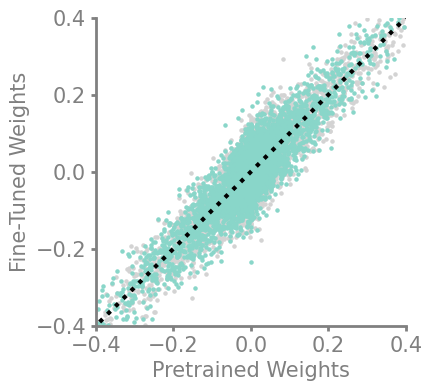

In [ ]:
demo_model(random)

### Large Final Value

In [ ]:
#| export
large_final = magnitude_criteria(torch.abs)

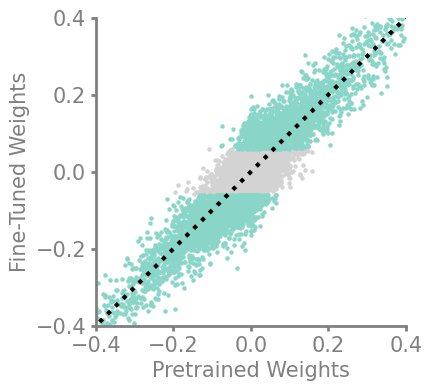

In [ ]:
demo_model(large_final)

### Squared Final Value

In [ ]:
#| export
squared_final = magnitude_criteria(torch.square)

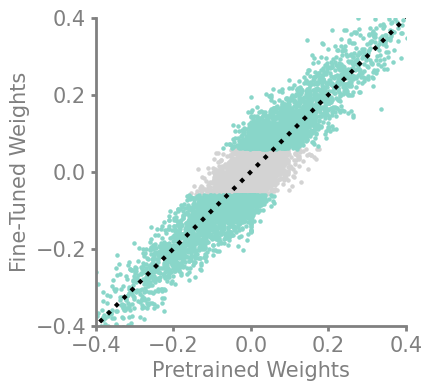

In [ ]:
demo_model(squared_final)

### Small Final Value

In [ ]:
#| export
small_final = magnitude_criteria(compose(torch.abs, torch.neg))

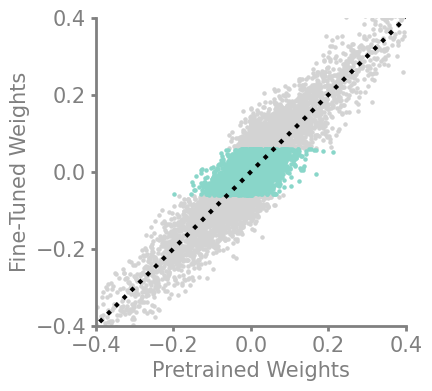

In [ ]:
demo_model(small_final)

## Init based criteria

In [ ]:
#| export
def init_based_criteria(transform_fn, output_fn=None, return_init=False, **kwargs):
     "Create a criteria that compares current weights to initial weights."
     return Criteria(transform_fn, needs_init=True, output_fn=output_fn, return_init=return_init, **kwargs)

### Large Init Value

In [ ]:
#| export
large_init = init_based_criteria(torch.abs, return_init=True)

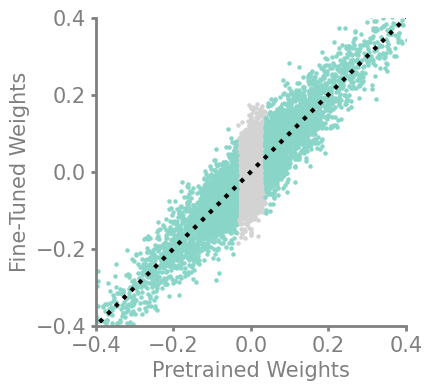

In [ ]:
demo_model(large_init)

### Small Init Value

In [ ]:
#| export
small_init = init_based_criteria(compose(torch.abs, torch.neg), return_init=True)

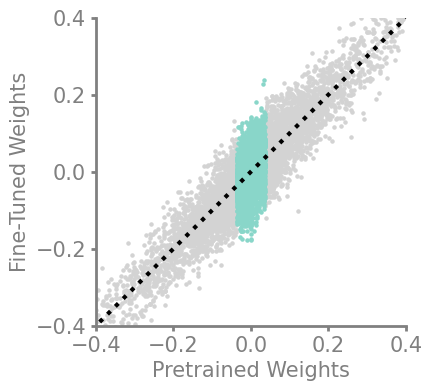

In [ ]:
demo_model(small_init)

### Large Init Large Final Value

In [ ]:
#| export
large_init_large_final = init_based_criteria(torch.abs, output_fn=torch.min)

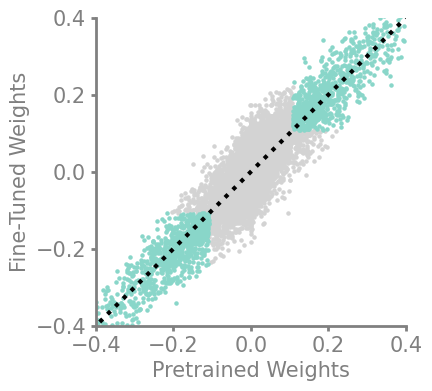

In [ ]:
demo_model(large_init_large_final, 80)

### Small Init Small Final Value

In [ ]:
#| export
small_init_small_final = init_based_criteria(torch.abs, output_fn=lambda x,y: torch.neg(torch.max(x,y)))

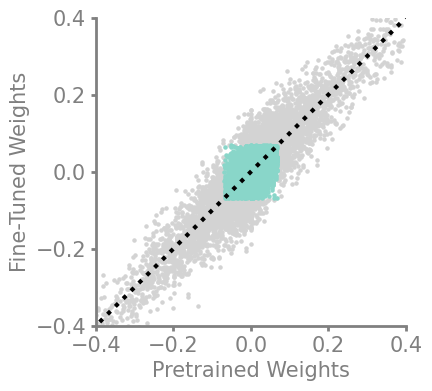

In [ ]:
demo_model(small_init_small_final)

### Increasing Magnitude

In [ ]:
#| export
magnitude_increase = init_based_criteria(torch.abs, output_fn= torch.sub)

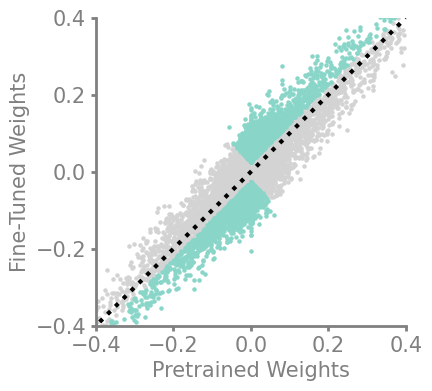

In [ ]:
demo_model(magnitude_increase, 60)

### Movement Pruning

In [ ]:
#| export
movement = init_based_criteria(noop, output_fn= lambda x,y: torch.abs(torch.sub(x,y)))

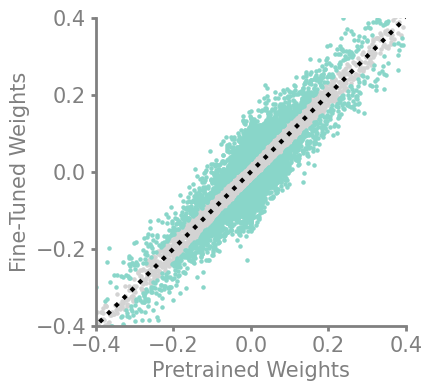

In [ ]:
demo_model(movement)

In [ ]:
movmag = init_based_criteria(noop, output_fn=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))

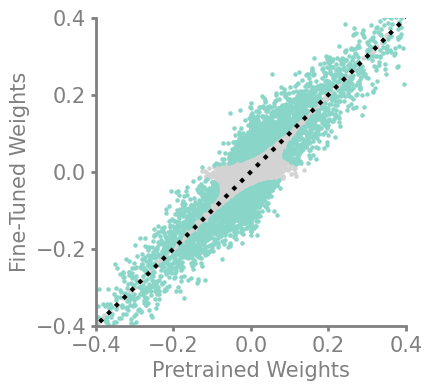

In [ ]:
demo_model(movmag)

## Update based criteria

In [ ]:
#| export
def update_based_criteria(transform_fn, output_fn=None, **kwargs):
     "Create a criteria that compares current weights to previous iteration weights."
     return Criteria(transform_fn, needs_update=True, output_fn=output_fn, **kwargs)

The following criteria use an updating value of the weights, i.e. the value from the previous iteration of training, instead of the initialization value to better capture the training dynamics.

### Updating Magnitude Increase

In [ ]:
#| export
updating_magnitude_increase = update_based_criteria(torch.abs, output_fn= lambda x,y: torch.sub(x,y))

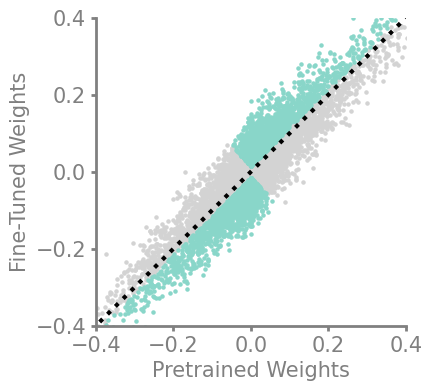

In [ ]:
demo_model(updating_magnitude_increase)

### Updating Movement

In [ ]:
#| export
updating_movement = update_based_criteria(noop, output_fn= lambda x,y: torch.abs(torch.sub(x,y)))

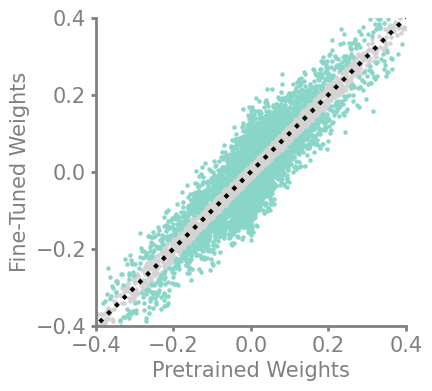

In [ ]:
demo_model(updating_movement, 50)

### Updating mov-magnitude

In [ ]:
#| export
updating_movmag = update_based_criteria(noop, output_fn=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))

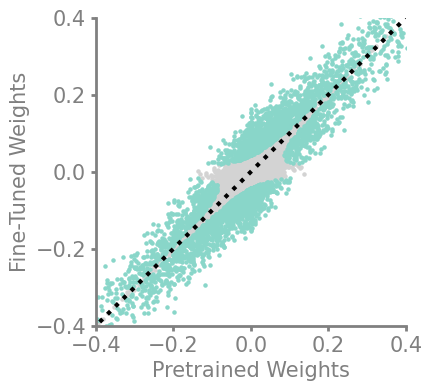

In [ ]:
demo_model(updating_movmag)

In [ ]:
#| export
criterias = (
    'random',              # Random scores
    'large_final',         # Large absolute weight values
    'small_final',         # Small absolute weight values
    'squared_final',       # Squared weight values
    'large_init',          # Large initial weight values
    'small_init',          # Small initial weight values
    'large_init_large_final',  # Minimum of initial and final magnitude
    'small_init_small_final',  # Maximum of initial and final magnitude (negated)
    'magnitude_increase',      # Increase in magnitude from init
    'movement',                # Absolute change from init
    'updating_magnitude_increase',  # Increase in magnitude from previous step
    'updating_movement',           # Absolute change from previous step
    'movmag',                      # Movement * magnitude from init
    'updating_movmag'              # Movement * magnitude from previous step
 )

def available_criterias():
    "Return the list of available criteria names"
    return criterias

# New Ideas

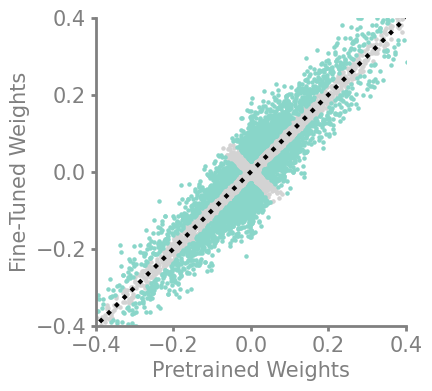

In [ ]:
updating_magnitude_increase = Criteria(torch.abs, needs_update=True, output_fn= lambda x,y: torch.abs(torch.sub(x,y)))

demo_model(updating_magnitude_increase)

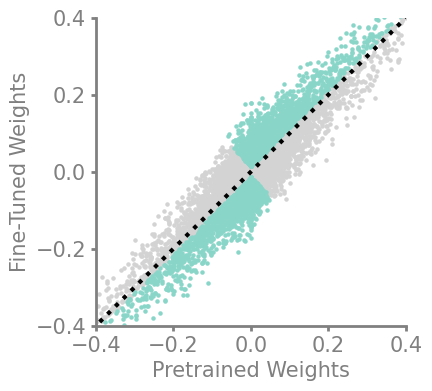

In [ ]:
updating_magnitude_increase = Criteria(torch.abs, needs_update=True, output_fn= lambda x,y: torch.sub(x,y))

demo_model(updating_magnitude_increase)

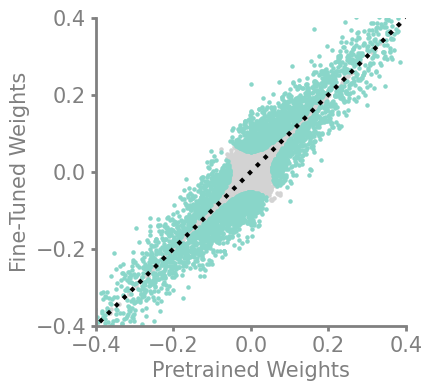

In [ ]:
updating_magnitude_increase = Criteria(torch.square, needs_update=True, output_fn= lambda x,y: torch.abs(torch.sub(x,y)))

demo_model(updating_magnitude_increase)

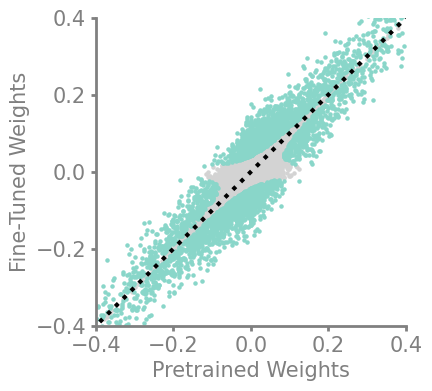

In [ ]:
updating_movmag = Criteria(noop, needs_update=True, output_fn=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))
demo_model(updating_movmag)

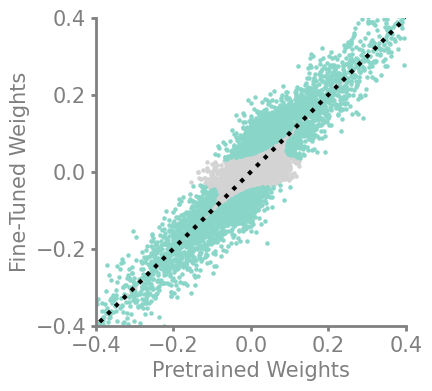

In [ ]:
updating_movmag = Criteria(noop, needs_update=True, output_fn=lambda x,y: torch.abs(torch.mul(torch.square(x), torch.sub(x,y))))
demo_model(updating_movmag)

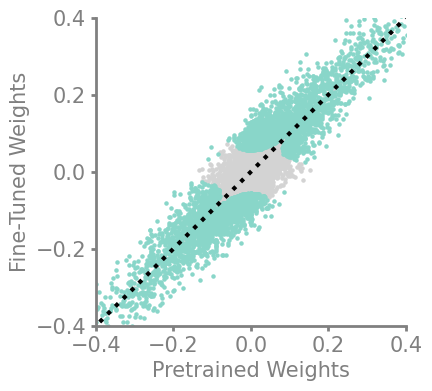

In [ ]:
updating_movmag = Criteria(torch.square, needs_update=True, output_fn=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))
#updating_movmag = Criteria(noop, needs_update=True, output_fn=lambda x,y: torch.mul(x, torch.sub(x,y)))
demo_model(updating_movmag)

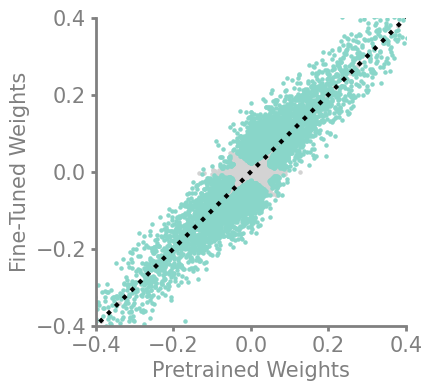

In [ ]:
updating_movmag = Criteria(torch.abs, needs_update=True, output_fn=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))
#updating_movmag = Criteria(noop, needs_update=True, output_fn=lambda x,y: torch.mul(x, torch.sub(x,y)))
demo_model(updating_movmag, 30)

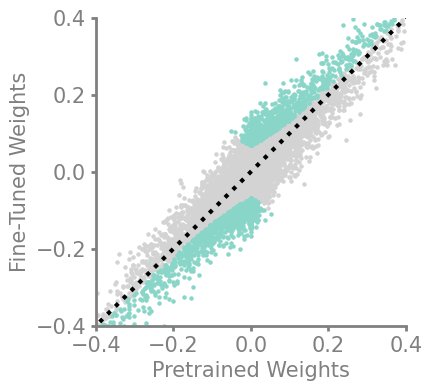

In [ ]:
updating_movmag = Criteria(torch.abs, needs_update=True, output_fn=lambda x,y: torch.mul(x, torch.sub(x,y)))

demo_model(updating_movmag, 80)

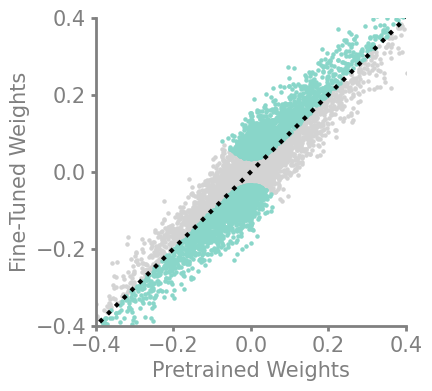

In [ ]:
updating_movmag = Criteria(torch.square, needs_update=True, output_fn=lambda x,y: torch.mul(x, torch.sub(x,y)))

demo_model(updating_movmag)

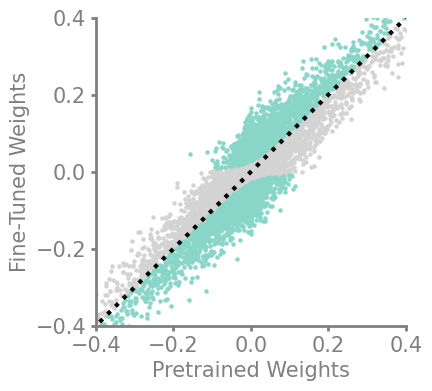

In [ ]:
updating_movmag = Criteria(noop, needs_update=True, output_fn=lambda x,y: torch.mul(x, torch.sub(x,y)))

demo_model(updating_movmag)

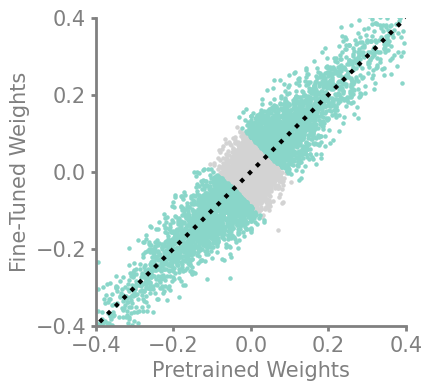

In [ ]:
updating_movement = Criteria(noop, needs_update=True, output_fn= lambda x,y: torch.abs(torch.sub(-x,y)))
demo_model(updating_movement, 50)

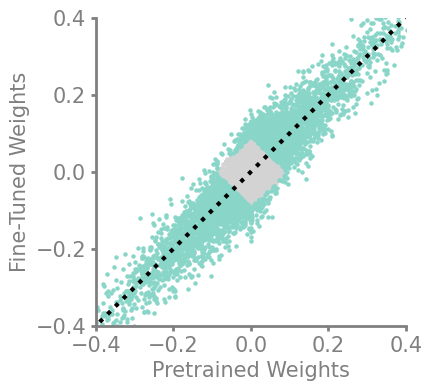

In [ ]:
updating_movement = Criteria(torch.abs, needs_update=True, output_fn= lambda x,y: torch.abs(torch.sub(-x,y)))
demo_model(updating_movement)

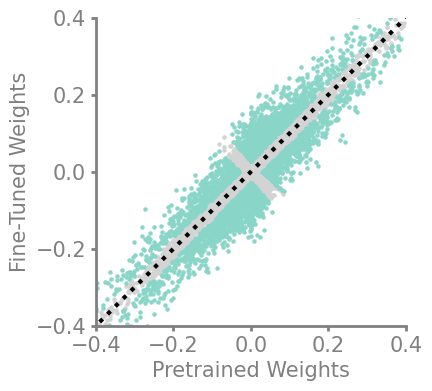

In [ ]:
updating_movement = Criteria(torch.abs, needs_update=True, output_fn= lambda x,y: torch.abs(torch.cosh(torch.sub(x,y))))
demo_model(updating_movement)

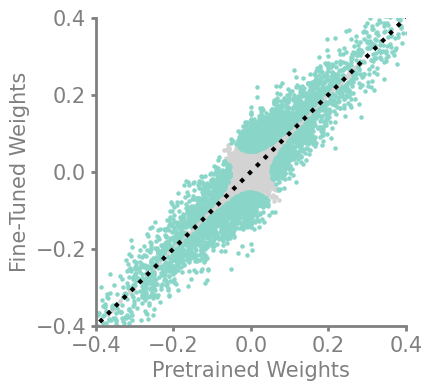

In [ ]:
updating_movement = Criteria(torch.square, needs_update=True, output_fn= lambda x,y: torch.abs(torch.sub(x,y)))
demo_model(updating_movement)

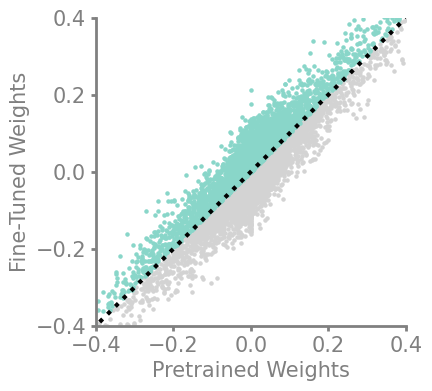

In [ ]:
updating_movement = Criteria(noop, needs_update=True, output_fn= lambda x,y: torch.sub(x,y))
demo_model(updating_movement)

In [ ]:
mine = partial(torch.pow, exponent=4)

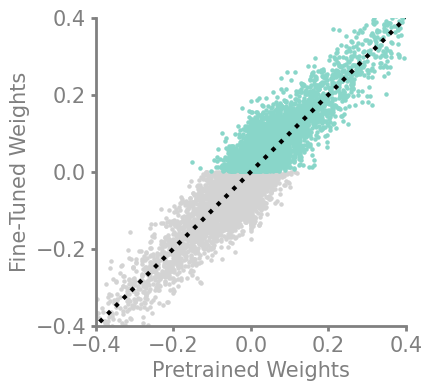

In [ ]:
large_final = Criteria(torch.frac)
demo_model(large_final)

### First order Taylor expansion on the weight (as per [Nvidia Taylor Pruning](https://github.com/NVlabs/Taylor_pruning/blob/master/pruning_engine.py))

In [ ]:
#| export
def grad_crit(
    m: nn.Module,  # module to compute gradient-based importance for
    g: str,        # granularity specification
) -> torch.Tensor:
    """First order Taylor expansion criterion for weight importance (Nvidia Taylor Pruning)."""
    try:
        dim = listify(Granularities.get_dim(m, g))
    except KeyError:
        raise ValueError(f'Invalid granularity "{g}" for module type {type(m).__name__}')
    
    if m.weight.grad is not None:
        return (m.weight * m.weight.grad)[None].pow(2).mean(dim=dim, keepdim=True).squeeze(0)
    else:
        return m.weight[None].pow(2).mean(dim=dim, keepdim=True).squeeze(0)

In [ ]:
scores = torch.randn(100).abs()
normed = Normalizer.standardization(scores)

In [ ]:
#| hide
from fastcore.test import *

# Reducer produces different results for sum vs mean on non-singleton dims
w = torch.randn(16, 3, 3, 3)
# dim=[0] is a no-op after [None] expansion (singleton), so use dim=[1]
test_ne(Reducer.sum(w, dim=[1]), Reducer.mean(w, dim=[1]))

# Normalizer.standardization → values in [0, 1] range (min-max normalization)
scores = torch.randn(100).abs()
normed = Normalizer.standardization(scores)
test_close(normed.min().item(), 0.0, eps=1e-5)
test_close(normed.max().item(), 1.0, eps=1e-5)

# Normalizer.max → max value is 1.0
max_normed = Normalizer.max(torch.randn(100).abs())
test_close(max_normed.max().item(), 1.0, eps=1e-6)
assert max_normed.min() >= 0.0

# Normalizer.gaussian → approximately zero mean
gauss = Normalizer.gaussian(torch.randn(1000))
test_close(gauss.mean().item(), 0.0, eps=0.1)

# large_final returns scores with correct shape
conv = nn.Conv2d(3, 16, 3)
scores = large_final(conv, 'weight')
test_eq(scores.shape, conv.weight.shape)

# random produces different scores each call
test_ne(random(conv, 'weight'), random(conv, 'weight'))

# Criteria with both needs_init and needs_update raises AssertionError
with ExceptionExpected(AssertionError):
    Criteria(torch.abs, needs_init=True, needs_update=True)

# grad_crit returns tensor of correct shape
conv2 = nn.Conv2d(3, 16, 3)
grad_scores = grad_crit(conv2, 'weight')
test_eq(grad_scores.shape, conv2.weight.shape)

# available_criterias returns tuple of strings
crit_list = available_criterias()
assert 'large_final' in crit_list
assert 'random' in crit_list
assert len(crit_list) > 0

---

## See Also

- [Sparsifier](../sparse/sparsifier.html) - Apply sparsification using these criteria
- [Pruner](../prune/pruner.html) - Structured pruning with importance scoring
- [Granularity](granularity.html) - Control what gets pruned (weights, filters, etc.)